In [1]:
from imports import *
from exactDiagMethods import perform_exact_diag, build_exact_diag_hamiltonian
from globalMethods import build_initial_states, output_results
from vqteMethods import  hamiltonian_generation, perform_vqte


In [2]:
# Initialize the simulation parameters
def main():
    gamma_L = 2
    gamma_R = 3

    eps = 1.0

    mu_L= 1
    mu_R= 2

    # Temperature of Reserviors
    T_L = 1
    T_R= 1

    time = 1.5
    dt = 0.6
    nt = int(time/dt)

    beta_L=1/T_L
    beta_R=1/T_R
    F_L = 1/(np.exp(beta_L*(eps-mu_L))+1)
    F_R = 1/(np.exp(beta_R*(eps-mu_R))+1)


    # Generate Hamiltonians
    exact_diag_ham = build_exact_diag_hamiltonian(eps)
    ham_real, ham_imag = hamiltonian_generation(eps, gamma_L, gamma_R, F_R,F_L)
    print("Exact Diag Ham: ", exact_diag_ham)
    print("Ham real: ", ham_real)
    print("Ham imag: ", ham_imag)


    # Generate initial states
    vqte_init_state, exact_diag_init_state, ansatz, init_param_values = build_initial_states(ham_real)
    print("VQTE Initial State : " , vqte_init_state)
    print("Exact Initial : ", exact_diag_init_state)

    # Perform exact diagonalization
    exact_diag_results, time_points = perform_exact_diag(gamma_L, F_L, gamma_R, F_R, dt, nt, exact_diag_init_state, exact_diag_ham)

    # Perform vqte simulation
    vqte_results = perform_vqte(ham_real, ham_imag, vqte_init_state, dt, nt, ansatz, init_param_values)

    #Output results

    output_results(
    vqte_results, 
    exact_diag_results, 
    time_points, 
    mu_L, T_L, gamma_L, 
    mu_R, T_R, gamma_R)


    ## Run multiple cases w/ diff params w/ for loop
    ## Save results to txt file
    ## Plot each txt file to graph

    ## Bother Hirad


    ## Make x and y axis text bigger
    ## Remove param border


Operator:  [[0.+0.j 0.+0.j]
 [1.+0.j 0.+0.j]]
Operator:  [[0.+0.j 1.+0.j]
 [0.+0.j 0.+0.j]]
Operator:  [[0.+0.j 0.+0.j]
 [1.+0.j 0.+0.j]]
Operator:  [[0.+0.j 1.+0.j]
 [0.+0.j 0.+0.j]]
Initial expectation value of number operator: (-3.673940397442059e-16+5.39913521758269e-31j)
Step 0 out of 3
Step 1 out of 3
Step 2 out of 3
0.6415800230892804


C:\Users\tessa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\tessa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\tessa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\transforms.py:2875: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])


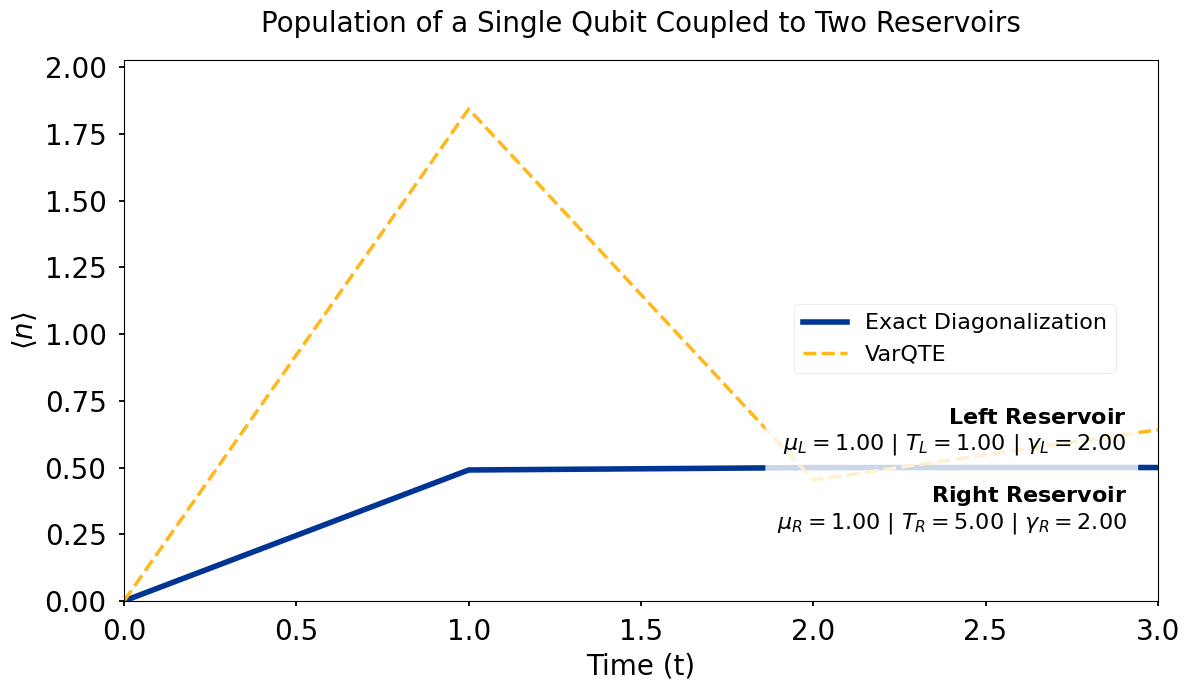

Operator:  [[0.        +0.j 0.        +0.j]
 [1.58113883+0.j 0.        +0.j]]
Operator:  [[0.        +0.j 1.58113883+0.j]
 [0.        +0.j 0.        +0.j]]
Operator:  [[0.        +0.j 0.        +0.j]
 [1.22474487+0.j 0.        +0.j]]
Operator:  [[0.        +0.j 1.22474487+0.j]
 [0.        +0.j 0.        +0.j]]
Initial expectation value of number operator: (-3.673940397442059e-16+5.39913521758269e-31j)
Step 0 out of 3
Step 1 out of 3
Step 2 out of 3
0.3742535421539897


C:\Users\tessa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\tessa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\tessa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\transforms.py:2875: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])


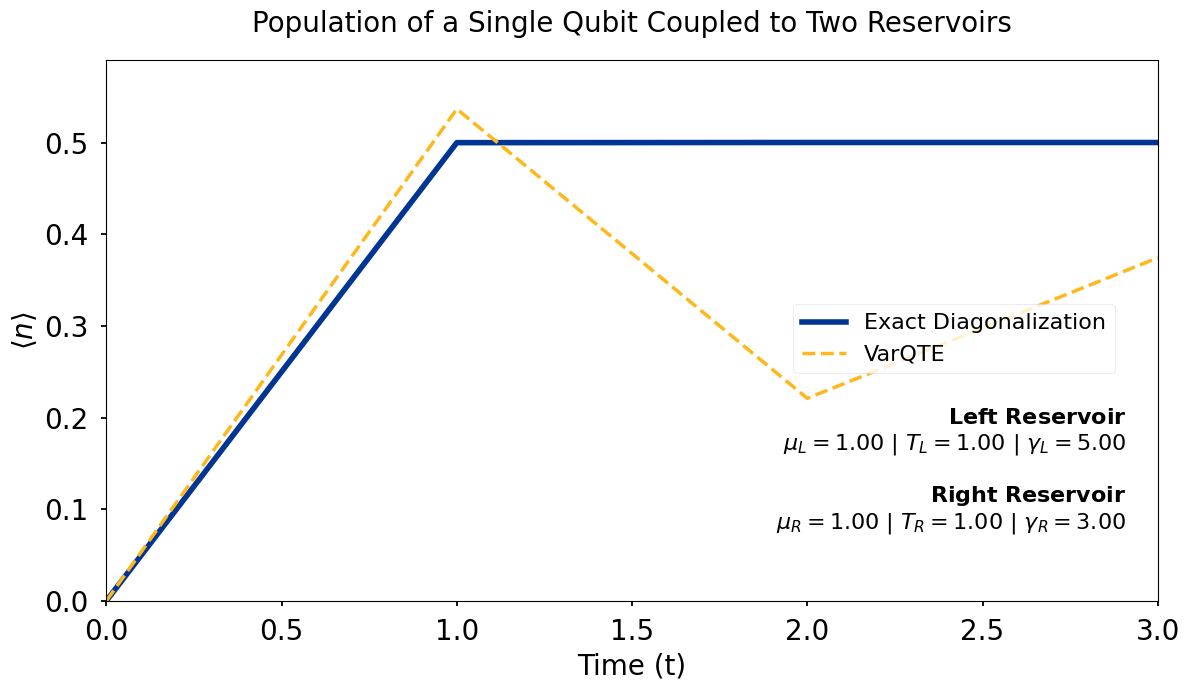

Operator:  [[0.+0.j 0.+0.j]
 [1.+0.j 0.+0.j]]
Operator:  [[0.+0.j 1.+0.j]
 [0.+0.j 0.+0.j]]
Operator:  [[0.        +0.j 0.        +0.j]
 [0.86895416+0.j 0.        +0.j]]
Operator:  [[0.        +0.j 1.11575923+0.j]
 [0.        +0.j 0.        +0.j]]
Initial expectation value of number operator: (-3.673940397442059e-16+5.39913521758269e-31j)
Step 0 out of 3
Step 1 out of 3
Step 2 out of 3
-4.006521540330214


C:\Users\tessa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\tessa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\tessa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\transforms.py:2875: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])


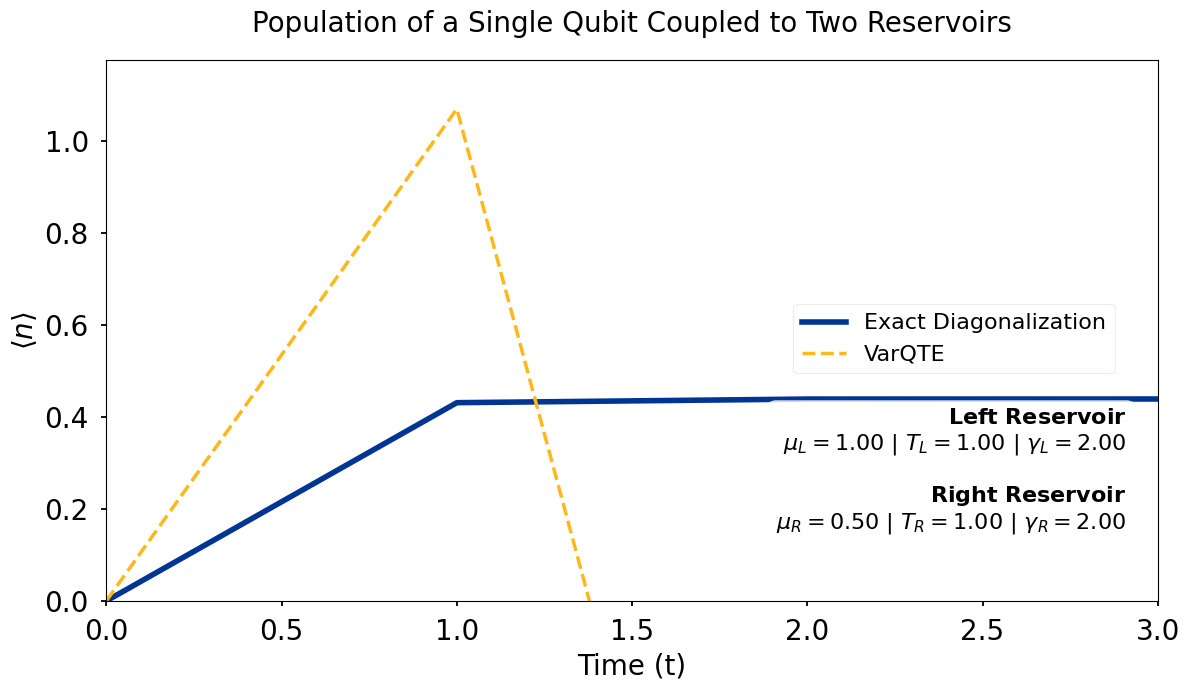

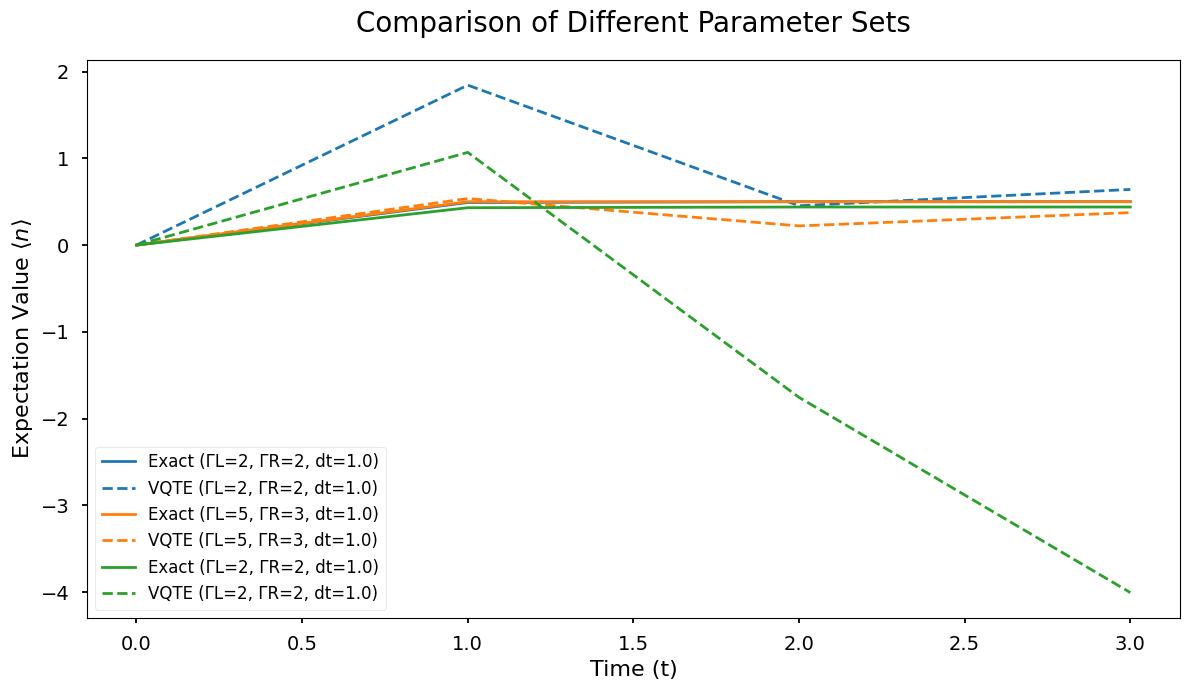

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os

def save_results_to_file(time_points, exact_results, vqte_results, filename):
    """Saves results to file, handling complex numbers by taking their real parts"""
    with open(filename, 'w') as f:
        f.write("Time\tExact_Real\tVQTE_Real\n")  # Simplified to just store real parts
        for t, exact, vqte in zip(time_points, exact_results, vqte_results):
            exact_real = exact.real if hasattr(exact, 'real') else float(exact)
            vqte_real = vqte.real if hasattr(vqte, 'real') else float(vqte)
            f.write(f"{t:.6f}\t{exact_real:.6f}\t{vqte_real:.6f}\n")

def load_results_from_file(filename):
    """Loads results from file"""
    time_points = []
    exact_results = []
    vqte_results = []
    with open(filename, 'r') as f:
        next(f)  # Skip header
        for line in f:
            t, exact, vqte = map(float, line.strip().split('\t'))
            time_points.append(t)
            exact_results.append(exact)
            vqte_results.append(vqte)
    return time_points, exact_results, vqte_results

def plot_saved_results(filenames, cases):
    """
    Plots results from saved files with case-specific legend visibility.
    
    Args:
        filenames (list): List of data files to plot
        cases (list): List of parameter dictionaries including 'show_legend' key
    """
    plt.style.use('seaborn-v0_8-talk')
    fig, ax = plt.subplots(figsize=(12, 7))
    
    for filename, params in zip(filenames, cases):
        time_points, exact_results, vqte_results = load_results_from_file(filename)
        label = f"ΓL={params['gamma_L']}, ΓR={params['gamma_R']}, dt={params['dt']:.1f}"
        
        # Only add labels if legend should be shown for this case
        exact_label = f'Exact ({label})' if params.get('show_legend', True) else None
        vqte_label = f'VQTE ({label})' if params.get('show_legend', True) else None
        
        ax.plot(time_points, exact_results, label=exact_label, 
               linestyle='-', linewidth=2, color=params.get('color', None))
        ax.plot(time_points, vqte_results, label=vqte_label, 
               linestyle='--', linewidth=2, color=params.get('color', None))
    
    ax.set_title("Comparison of Different Parameter Sets", fontsize=20, pad=20)
    ax.set_xlabel("Time (t)", fontsize=16)
    ax.set_ylabel("Expectation Value $\\langle n \\rangle$", fontsize=16)
    ax.tick_params(axis='both', labelsize=14)
    
    # Only show legend if any cases have show_legend=True
    if any(case.get('show_legend', True) for case in cases):
        ax.legend(fontsize=12, framealpha=0.8)
    
    ax.grid(False)
    plt.tight_layout()
    plt.show()

def output_results(
    vqte_results, 
    exact_diag_results, 
    time_points, 
    params  # Now takes the full params dictionary
):
    """
    Generates a plot with case-specific legend visibility.
    """
    plt.style.use('seaborn-v0_8-talk')
    fig, ax = plt.subplots(figsize=(12, 7))

    time_axis_vqte = np.linspace(0, np.max(time_points), len(vqte_results))

    # Only add labels if legend should be shown
    exact_label = 'Exact Diagonalization' if params.get('show_legend', True) else None
    vqte_label = 'VarQTE' if params.get('show_legend', True) else None
    
    ax.plot(time_points, exact_diag_results, label=exact_label, 
           linestyle='-', linewidth=4, color='#003594')
    ax.plot(time_axis_vqte, vqte_results, label=vqte_label, 
           linestyle='--', linewidth=2.5, color="#FFB81C")

    ax.set_title("Population of a Single Qubit Coupled to Two Reservoirs", 
                fontsize=20, pad=20)
    ax.set_xlabel("Time (t)", fontsize=20)
    ax.set_ylabel("$\\langle n \\rangle$", fontsize=20)
    
    params_text = (
        f"$\\bf{{Left~Reservoir}}$\n"
        f"$\\mu_L = {params['mu_L']:.2f}$ | $T_L = {params['T_L']:.2f}$ | $\\gamma_L = {params['gamma_L']:.2f}$\n\n"
        f"$\\bf{{Right~Reservoir}}$\n"
        f"$\\mu_R = {params['mu_R']:.2f}$ | $T_R = {params['T_R']:.2f}$ | $\\gamma_R = {params['gamma_R']:.2f}$"
    )
    
    param_box = ax.text(0.97, 0.12, params_text, transform=ax.transAxes, fontsize=16,
                       verticalalignment='bottom', horizontalalignment='right',
                       bbox=dict(facecolor='white', edgecolor='white', alpha=0.8, boxstyle='round,pad=0.5'))
    
    if params.get('show_legend', True):
        legend = ax.legend(fontsize=16, loc='lower right', 
                          bbox_to_anchor=(0.97, 0.4),
                          frameon=True, framealpha=0.8,
                          facecolor='white', edgecolor='lightgray')
    
    ax.set_xlim(0, np.max(time_points)) 
    ax.set_ylim(bottom=0, top=np.max(np.concatenate([vqte_results, exact_diag_results])) * 1.1)
    
    ax.grid(False)
    ax.tick_params(axis='both', which='major', labelsize=20)
    fig.tight_layout()
    plt.show()

def run_multiple_cases():
    # Each case now includes show_legend parameter
    cases = [
        {
            'gamma_L': 2, 'gamma_R': 2, 'mu_L': 1, 'mu_R': 1, 
            'T_L': 1, 'T_R': 5, 'time': 3, 'dt': 0.001,
            'show_legend': True,  
            'color': '#1f77b4'  
        },
        {
            'gamma_L': 0.5, 'gamma_R': 0.7, 'mu_L': 1, 'mu_R': 1,
            'T_L': 1, 'T_R': 1, 'time': 3.0, 'dt': 0.001,
            'show_legend': True, 
            'color': '#ff7f0e'
        },
        {
            'gamma_L': 2, 'gamma_R': 2, 'mu_L': 3, 'mu_R': 1.5,
            'T_L': 1, 'T_R': 1, 'time': 3.0, 'dt': 0.001,
            'show_legend': True,  
            'color': '#2ca02c'
        }
    ]
    
    os.makedirs('simulation_results', exist_ok=True)
    filenames = []
    
    for i, params in enumerate(cases):
        eps = 1.0
        nt = int(params['time']/params['dt'])

        beta_L = 1/params['T_L']
        beta_R = 1/params['T_R']
        F_L = 1/(np.exp(beta_L*(eps-params['mu_L']))+1)
        F_R = 1/(np.exp(beta_R*(eps-params['mu_R']))+1)
        
        exact_diag_ham = build_exact_diag_hamiltonian(eps)
        ham_real, ham_imag = hamiltonian_generation(eps, params['gamma_L'], params['gamma_R'], F_R, F_L)
        vqte_init_state, exact_diag_init_state, ansatz, init_param_values = build_initial_states(ham_real)
        
        exact_diag_results, time_points = perform_exact_diag(
            params['gamma_L'], F_L, params['gamma_R'], F_R, 
            params['dt'], nt, exact_diag_init_state, exact_diag_ham
        )
        vqte_results = perform_vqte(
            ham_real, ham_imag, vqte_init_state, 
            params['dt'], nt, ansatz, init_param_values
        )
        print(vqte_results[-1])
        filename = f'simulation_results/case_{i+1}.txt'
        save_results_to_file(time_points, exact_diag_results, vqte_results, filename)
        filenames.append(filename)
        
        output_results(
            vqte_results, 
            exact_diag_results, 
            time_points, 
            params  # Pass the entire params dictionary
        )
    
    plot_saved_results(filenames, cases)

# Run the simulation
run_multiple_cases()
